In [0]:
import tensorflow as tf
from tensorflow import keras
import os
import gc
import numpy as np
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

Download the dataset, you can use shell commands or use pdl (Python Download Library)

In [3]:
!wget http://files.fast.ai/data/dogscats.zip

--2019-01-18 03:56:20--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip.3’

dogscats.zip.3        0%[                    ]       0  --.-KB/s               ^C


In [0]:
!unzip -qq -n dogscats.zip

In [2]:
PATH = "dogscats/"
!ls {PATH}

models	test_tatouage_grand_gris_haut  test_tatouage_petit_gris_milieu	 valid
sample	test_tatouage_petit_gris_bas   test_tatouage_petit_rouge_milieu
test1	test_tatouage_petit_gris_haut  train


Import matplotlib, cv2 and PIL for processing and displaying images

Import Tensorflow and related Keras modules

In [0]:
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import cv2
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


First lets check our data:

In [43]:
files = [0,0,0,0]
files[0] = PATH+'valid/cats' + os.listdir(PATH+'valid/cats')[0]
files[1] = PATH+'valid/cats' + os.listdir(PATH+'valid/cats')[1]
files[2] = PATH+'valid/dogs' + os.listdir(PATH+'valid/dogs')[2]
files[3] = PATH+'valid/dogs' + os.listdir(PATH+'valid/dogs')[3]
files


['dogscats/valid/catscat.4150.jpg',
 'dogscats/valid/catscat.3220.jpg',
 'dogscats/valid/dogsdog.11206.jpg',
 'dogscats/valid/dogsdog.11345.jpg']

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


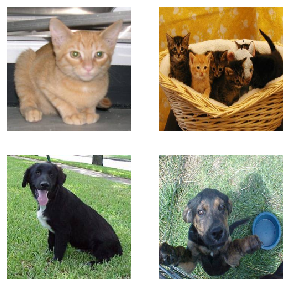

In [47]:
files = [0,0,0,0]
files[0] = PATH+'valid/cats/' + os.listdir(PATH+'valid/cats')[0]
files[1] = PATH+'valid/cats/' + os.listdir(PATH+'valid/cats')[1]
files[2] = PATH+'valid/dogs/' + os.listdir(PATH+'valid/dogs')[2]
files[3] = PATH+'valid/dogs/' + os.listdir(PATH+'valid/dogs')[3]
files_ = [cv2.imread(file) for file in files]
images=[cv2.cvtColor(cv2.resize(file,(224,224)), cv2.COLOR_BGR2RGB) for file in files_]

plt.figure(figsize=(5,5))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  plt.imshow(images[i])


# Conception du réseau de neurone: ResNet

In [52]:
batch_size = 64
model = ResNet50(weights='imagenet',include_top=False)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs=model.input, outputs=predictions)

split_at = 140
for layer in final_model.layers[:split_at]: layer.trainable = False
for layer in final_model.layers[split_at:]: layer.trainable = True
  
final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
final_model.save('resnet_dogsandcats.h5')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
model = load_model('resnet_dogsandcats.h5')
model.summary()

In [0]:
from IPython import display
tf.keras.utils.plot_model(model, to_file='ResNet50.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('ResNet50.png'))


In [57]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        PATH+'train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        PATH+'valid',
        shuffle=False,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [58]:
%%time

history = model.fit_generator(
        train_generator,
        steps_per_epoch=23000 // batch_size,
        epochs=3,
        workers=4,
        validation_data=validation_generator,
        validation_steps=2000 // batch_size)

Epoch 1/3
359/359 [==============================] - 333s 926ms/step - loss: 0.1080 - acc: 0.9702 - val_loss: 6.6244 - val_acc: 0.5696
Epoch 2/3
359/359 [==============================] - 318s 886ms/step - loss: 0.0424 - acc: 0.9853 - val_loss: 0.1445 - val_acc: 0.9803
Epoch 3/3
359/359 [==============================] - 319s 887ms/step - loss: 0.0335 - acc: 0.9890 - val_loss: 0.1182 - val_acc: 0.9793
CPU times: user 29min 31s, sys: 1min 1s, total: 30min 32s
Wall time: 16min 11s


In [0]:
model.save('resnet_dogsandcats-dgx.h5')

In [0]:
model = load_model('resnet_dogsandcats-dgx.h5')

In [0]:
#image = np.reshape(image, (1, 224, 224, 3))

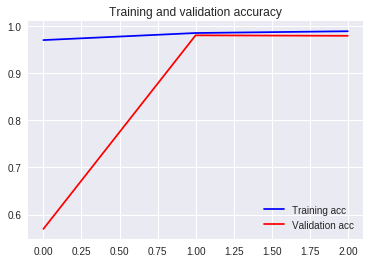

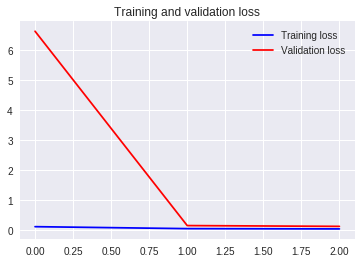

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#Préparation des base de données de test

#Définition du code de tatouage

In [67]:
!wget https://www.wfonts.com/download/data/2016/04/04/arial/arial.zip
!unzip -n arial.zip
#!ls

--2019-01-18 01:23:44--  https://www.wfonts.com/download/data/2016/04/04/arial/arial.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285542 (279K) [application/octetstream]
Saving to: ‘arial.zip’

arial.zip           100%[===================>] 278.85K   582KB/s    in 0.5s    

2019-01-18 01:23:46 (582 KB/s) - ‘arial.zip’ saved [285542/285542]

Archive:  arial.zip
ARIALI.TTF:  mismatching "local" filename (design.graffiti.JungleStandard.ttf),
         continuing with "central" filename version
  inflating: ARIALI.TTF              
file #2:  bad zipfile offset (local header sig):  39566
  inflating: sharefonts.net.txt      


In [0]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
 
 
def watermark_text(input_image_path,
                   output_image_path,
                   text, color, size, pos):
  
    photo = Image.open(input_image_path)
 
    # make the image editable
    drawing = ImageDraw.Draw(photo)

    font = ImageFont.truetype("ARIALI.TTF", size)
    drawing.text(pos, text, fill=color, font=font)
    photo.show()
    photo.save(output_image_path)

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image(test, index):
    if test == 1:
      img = cv2.imread('dogscats/test1/%d.jpg' % index)
    
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img


# Opération de tatouage:

In [0]:
from tqdm import *

In [0]:
test_num = 12500

In [75]:
#Grand, gris et en haut
!mkdir -p dogscats/test_tatouage_grand_gris_haut
text='Tatouage_A_M_N'
color = (150, 150, 150)
size = 300
pos = (0,0)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_grand_gris_haut/%d.jpg' % a, text, color, size, pos)
  

100%|██████████| 12500/12500 [02:36<00:00, 79.98it/s]


In [20]:
#Petit, gris et en haut
!mkdir -p dogscats/test_tatouage_petit_gris_haut
text='Tatouage_A_M_N'
color = (150, 150, 150)
size = 50
pos = (0,0)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_gris_haut/%d.jpg' % a, text, color, size, pos)
  

100%|██████████| 12500/12500 [01:59<00:00, 104.35it/s]


In [21]:
#Petit, gris et en milieu
!mkdir -p dogscats/test_tatouage_petit_gris_milieu
text='Tatouage_A_M_N'
color = (150, 150, 150)
size = 50
pos = (0,110)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_gris_milieu/%d.jpg' % a, text, color, size, pos)

100%|██████████| 12500/12500 [01:54<00:00, 108.88it/s]


In [22]:
#Petit, gris et en bas
!mkdir -p dogscats/test_tatouage_petit_gris_bas
text='Tatouage_A_M_N'
color = (150, 150, 150)
size = 50
pos = (0,200)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_gris_bas/%d.jpg' % a, text, color, size, pos)

100%|██████████| 12500/12500 [01:51<00:00, 111.70it/s]


In [23]:
#Petit, rouge et au milieu
!mkdir -p dogscats/test_tatouage_petit_rouge_milieu
text='Tatouage_A_M_N'
color = (0, 0, 200)
size = 50
pos = (0,110)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_rouge_milieu/%d.jpg' % a, text, color, size, pos)

100%|██████████| 12500/12500 [01:52<00:00, 110.95it/s]


In [11]:
#Petit, vert et au milieu
!mkdir -p dogscats/test_tatouage_petit_vert_milieu
text='Tatouage_A_M_N'
color = (0, 200, 0)
size = 50
pos = (0,110)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_vert_milieu/%d.jpg' % a, text, color, size, pos)

100%|██████████| 12500/12500 [02:05<00:00, 99.41it/s] 


In [12]:
#Petit, bleu et au milieu
!mkdir -p dogscats/test_tatouage_petit_bleu_milieu
text='Tatouage_A_M_N'
color = (200, 0 ,0)
size = 50
pos = (0,110)
for i in tqdm(range(test_num)):
  a=i+1
  watermark_text('dogscats/test1/%d.jpg' % a, 'dogscats/test_tatouage_petit_bleu_milieu/%d.jpg' % a, text, color, size, pos)

100%|██████████| 12500/12500 [01:55<00:00, 108.48it/s]


# DEBUT DES TESTS

# Prediction du test dataset sans tatouage

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image(index):
 
    img = cv2.imread('dogscats/test1/%d.jpg' % index)
    
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img


In [10]:

image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

100%|██████████| 12500/12500 [00:43<00:00, 285.29it/s]


In [11]:
predictions = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p)

with open('result.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 97s 8ms/step


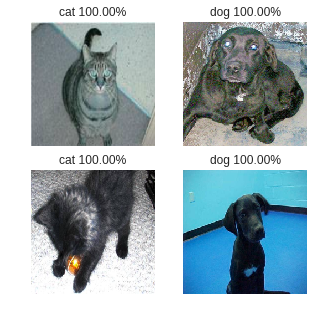

In [13]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image(a)
    prediction = predictions[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


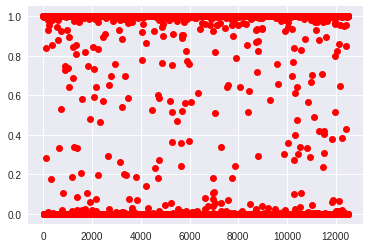

In [14]:
plt.plot(predictions,'ro')

In [17]:
result = [0,0]
for i in range(test_num):
  if predictions[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(51.080000000000005, 48.92)

# TEST1: Prediction du test dataset avec tatouage grand, gris et au centre

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_1(index):
    img = cv2.imread('dogscats/test_tatouage_grand_gris_haut/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [10]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_1(i+1)

100%|██████████| 12500/12500 [00:36<00:00, 347.89it/s]


In [12]:
predictions_tatouage_1 = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_1):
    s += '%d,%f\n' % (i+1, p)

with open('result_1.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 92s 7ms/step


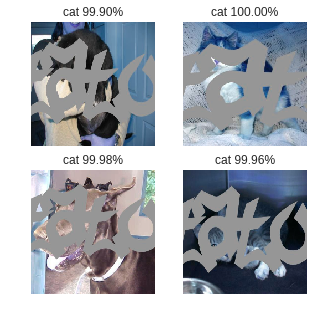

In [15]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_1(a)
    prediction = predictions_tatouage_1[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


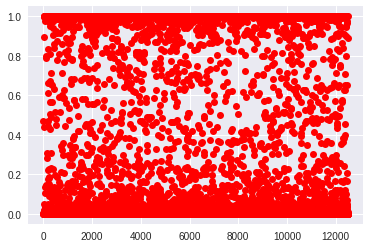

In [19]:
plt.plot(predictions_tatouage_1,'ro')

In [18]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_1[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(85.08, 14.92)

# TEST 2: Prediction du test dataset avec tatouage petit, gris et au milieu

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_2(index):
    img = cv2.imread('dogscats/test_tatouage_petit_gris_haut/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [13]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_2(i+1)

100%|██████████| 12500/12500 [00:37<00:00, 333.67it/s]


In [15]:
predictions_tatouage_2 = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_2):
    s += '%d,%f\n' % (i+1, p)

with open('result_2.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 92s 7ms/step


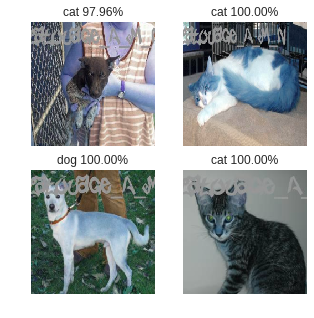

In [16]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_2(a)
    prediction = predictions_tatouage_2[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


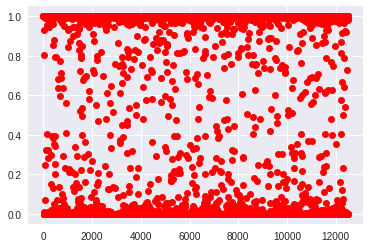

In [17]:
plt.plot(predictions_tatouage_2,'ro')

In [18]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_2[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(55.008, 44.992)

# TEST 3: Prediction du test dataset avec tatouage petit, gris et au milieu

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_3(index):
    img = cv2.imread('dogscats/test_tatouage_petit_gris_milieu/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [10]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_3(i+1)

100%|██████████| 12500/12500 [00:37<00:00, 335.57it/s]


In [11]:
predictions_tatouage_3 = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_3):
    s += '%d,%f\n' % (i+1, p)

with open('result_3.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 96s 8ms/step


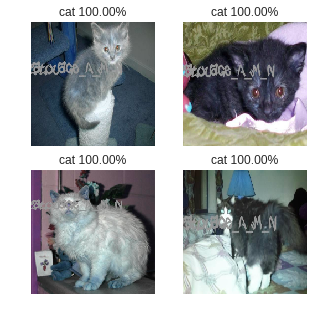

In [12]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_3(a)
    prediction = predictions_tatouage_3[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


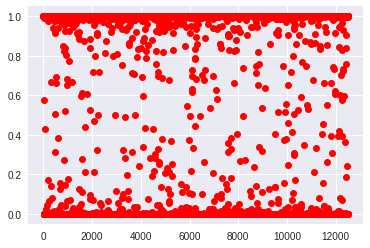

In [13]:
plt.plot(predictions_tatouage_3,'ro')

In [14]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_3[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(52.656000000000006, 47.344)

# TEST 4: Prediction du test dataset avec tatouage petit, gris et en bas

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_4(index):
    img = cv2.imread('dogscats/test_tatouage_petit_gris_bas/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [10]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_4(i+1)

100%|██████████| 12500/12500 [00:36<00:00, 338.56it/s]


In [11]:
predictions_tatouage_4 = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_4):
    s += '%d,%f\n' % (i+1, p)

with open('result_4.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 95s 8ms/step


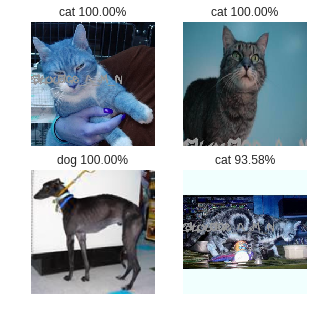

In [12]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_4(a)
    prediction = predictions_tatouage_4[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


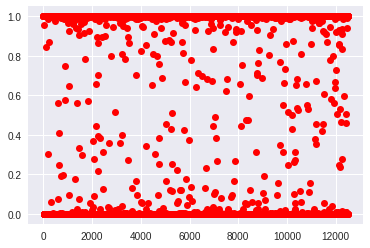

In [13]:
plt.plot(predictions_tatouage_4,'ro')

In [14]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_4[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(51.632, 48.368)

# TEST 5_1: Prediction du test dataset avec tatouage rouge, petit et au milieu

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import gc
import numpy as np
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
PATH = "dogscats/"
!ls {PATH}
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import cv2
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tqdm import *
model = load_model('resnet_dogsandcats-dgx.h5')
test_num = 12500

models	test_tatouage_grand_gris_haut  test_tatouage_petit_gris_milieu	 valid
sample	test_tatouage_petit_gris_bas   test_tatouage_petit_rouge_milieu
test1	test_tatouage_petit_gris_haut  train


In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_5(index):
    img = cv2.imread('dogscats/test_tatouage_petit_rouge_milieu/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [3]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_5(i+1)

100%|██████████| 12500/12500 [00:37<00:00, 334.77it/s]


In [4]:
predictions_tatouage_5 = model.predict(preprocess_input(image_matrix), verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_5):
    s += '%d,%f\n' % (i+1, p)

with open('result_5.csv', 'w') as f:
    f.write(s)

12500/12500 [==============================] - 95s 8ms/step


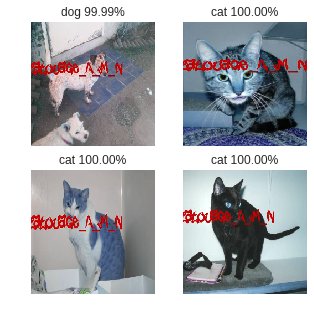

In [5]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_5(a)
    prediction = predictions_tatouage_5[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


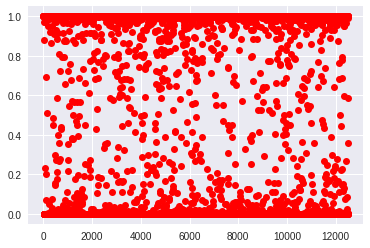

In [6]:
plt.plot(predictions_tatouage_5,'ro')

In [7]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_5[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(55.376000000000005, 44.624)

# TEST 5_2: Prediction du test dataset avec tatouage vert, petit et au milieu

In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_5_2(index):
    img = cv2.imread('dogscats/test_tatouage_petit_vert_milieu/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [3]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_5_2(i+1)

100%|██████████| 12500/12500 [00:38<00:00, 326.17it/s]


In [4]:
predictions_tatouage_5_2 = model.predict(preprocess_input(image_matrix), verbose=1)

12500/12500 [==============================] - 95s 8ms/step


In [0]:
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_5_2):
    s += '%d,%f\n' % (i+1, p)

with open('result_5_2.csv', 'w') as f:
    f.write(s)

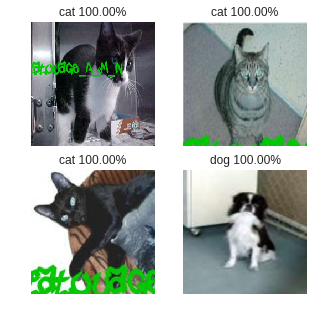

In [6]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_5_2(a)
    prediction = predictions_tatouage_5_2[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


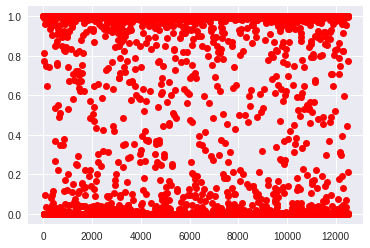

In [7]:
plt.plot(predictions_tatouage_5_2,'ro')

In [8]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_5_2[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(55.647999999999996, 44.352000000000004)

# TEST 5_3: Prediction du test dataset avec tatouage bleu, petit et au milieu

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import gc
import numpy as np
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
PATH = "dogscats/"
!ls {PATH}
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import cv2
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tqdm import *
model = load_model('resnet_dogsandcats-dgx.h5')
test_num = 12500

1.jpg				 test_tatouage_petit_gris_haut
models				 test_tatouage_petit_gris_milieu
sample				 test_tatouage_petit_rouge_milieu
test1				 test_tatouage_petit_vert_milieu
test_tatouage_grand_gris_haut	 train
test_tatouage_petit_bleu_milieu  valid
test_tatouage_petit_gris_bas


In [0]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)

def get_image_tatouage_5_3(index):
    img = cv2.imread('dogscats/test_tatouage_petit_bleu_milieu/%d.jpg' % index)   
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=np.array(img)
    image = image.astype(np.float64)
    return img

In [7]:
image_matrix = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image_tatouage_5_3(i+1)

100%|██████████| 12500/12500 [00:38<00:00, 325.64it/s]


In [8]:
predictions_tatouage_5_3 = model.predict(preprocess_input(image_matrix), verbose=1)

12500/12500 [==============================] - 96s 8ms/step


In [0]:
s = 'id,label\n'
for i, p in enumerate(predictions_tatouage_5_3):
    s += '%d,%f\n' % (i+1, p)

with open('result_5.csv', 'w') as f:
    f.write(s)

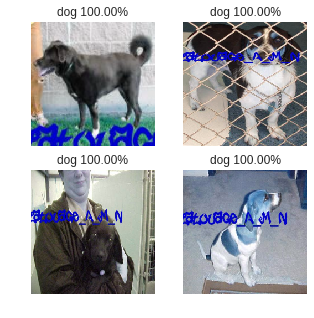

In [10]:
import random
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
for i in range(4):
    a = random.randint(1, test_num)
    x = get_image_tatouage_5_3(a)
    prediction = predictions_tatouage_5_3[a-1]
    #x = get_image(random.randint(1, test_num))
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(2, 2, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


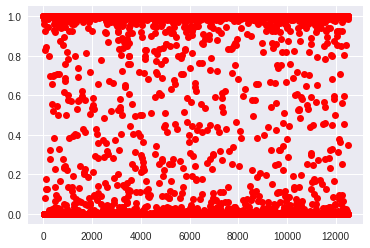

In [11]:
plt.plot(predictions_tatouage_5_3,'ro')

In [12]:
result = [0,0]
for i in range(test_num):
  if predictions_tatouage_5_3[i] < 0.5:
    result[0] += 1
  else:
    result[1] += 1
    
(result[0]/test_num*100, result[1]/test_num*100)

(55.767999999999994, 44.232)